In [4]:
import os
import json
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 可选设置最大状态编号范围
STATE_MAX = 10  # 如果不确定可以先设置大一点，如 12、13

def load_and_average_probabilities(folder):
    prob_sums = defaultdict(float)
    prob_counts = defaultdict(int)
    all_states = set()

    for fname in os.listdir(folder):
        if not fname.endswith(".json"):
            continue
        path = os.path.join(folder, fname)
        with open(path, "r") as f:
            data = json.load(f)
            probs = data.get("probabilities", {})
            for k, v in probs.items():
                # if k == "9-7":
                #     print(f"⚠️ {fname} has 8-7 = {v}")
                try:
                    old, new = map(int, k.split("-"))
                    # if old > STATE_MAX or new > STATE_MAX:
                    #     print(f"⚠️ Warning: Skip illegal state {old}-{new} in {fname}")
                    #     if k == "11-4" :
                    #         print(f"⚠️ {fname} has 11-4 = {v}")
                    #     continue
                    prob_sums[k] += v
                    prob_counts[k] += 1
                    all_states.add(old)
                    all_states.add(new)
                except Exception as e:
                    print(f"❌ Error parsing key {k} in {fname}: {e}")

    # 计算平均值
    avg_probs = {k: prob_sums[k] / prob_counts[k] for k in prob_sums}
    return avg_probs, max(all_states) if all_states else 0

def plot_heatmap(matrix, title, save_path=None):
    plt.figure(figsize=(10,8))
    sns.heatmap(matrix, annot=True, fmt=".3f", cmap="YlGnBu", 
                cbar_kws={'label': 'Transition Probability'})
    plt.title(title)
    plt.xlabel("New State")
    plt.ylabel("Old State")
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
        print(f"✅ Heatmap saved to: {save_path}")
    plt.show()

def main():
    folder = "./normal"  # JSON 文件夹路径
    avg_probs, max_state = load_and_average_probabilities(folder)

    # 打印结果（可写入文件）
    print("\n📊 Averaged transition probabilities:")
    for k in sorted(avg_probs.keys()):
        print(f'"{k}": {avg_probs[k]:.6f},')

    # 构建状态转移矩阵
    matrix = np.zeros((max_state + 1, max_state + 1))
    for key, val in avg_probs.items():
        old, new = map(int, key.split("-"))
        matrix[old-1][new-1] = val

    # # 画图
    # plot_heatmap(matrix, "Protocol State Transition Probability Heatmap", save_path="heatmap.png")

if __name__ == "__main__":
    main()


📊 Averaged transition probabilities:
"1-4": 0.048148,
"1-7": 0.140897,
"1-8": 0.835029,
"10-7": 0.777778,
"2-1": 0.058135,
"2-7": 0.951554,
"3-1": 1.000000,
"4-5": 0.250000,
"4-7": 0.166667,
"5-7": 0.250000,
"7-2": 1.000000,
"8-9": 1.000000,
"9-7": 0.974967,
"9-9": 0.030040,



📈 Summary:

📁 normal
  KL Mean: 6.2618, MIN: 2.0089
  JS Mean: 0.1848, MIN: 0.0732

📁 attack
  KL Mean: 26.9550, MIN: 19.6951
  JS Mean: 1.3030, MIN: 1.2249

📁 attackbody
  KL Mean: 40.3357, MIN: 39.9654
  JS Mean: 1.4221, MIN: 1.3711

📁 attackread
  KL Mean: 36.3089, MIN: 31.3617
  JS Mean: 1.2452, MIN: 0.9866

📁 mix
  KL Mean: 2.8479, MIN: 2.7187
  JS Mean: 0.9802, MIN: 0.8637


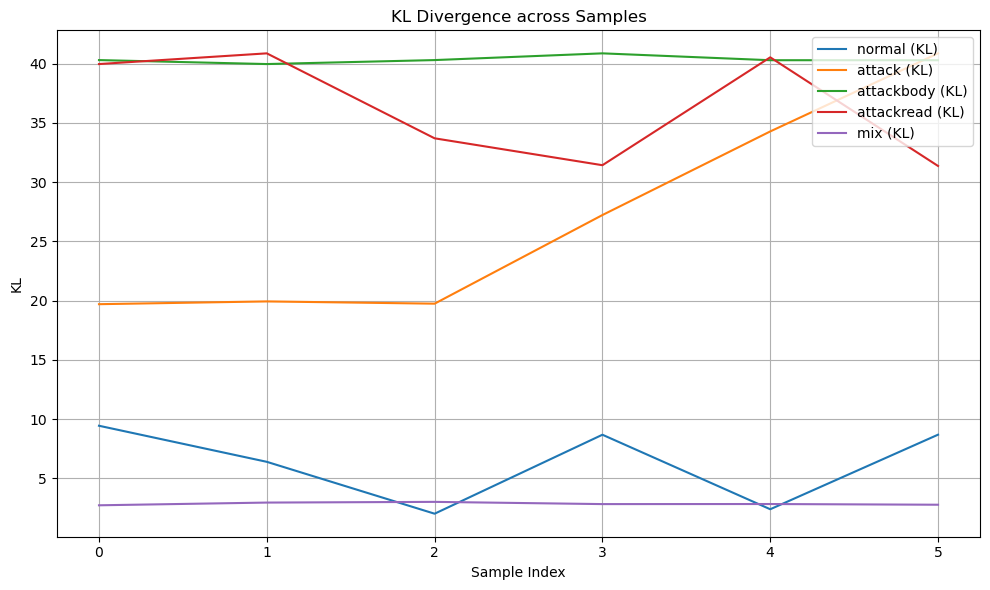

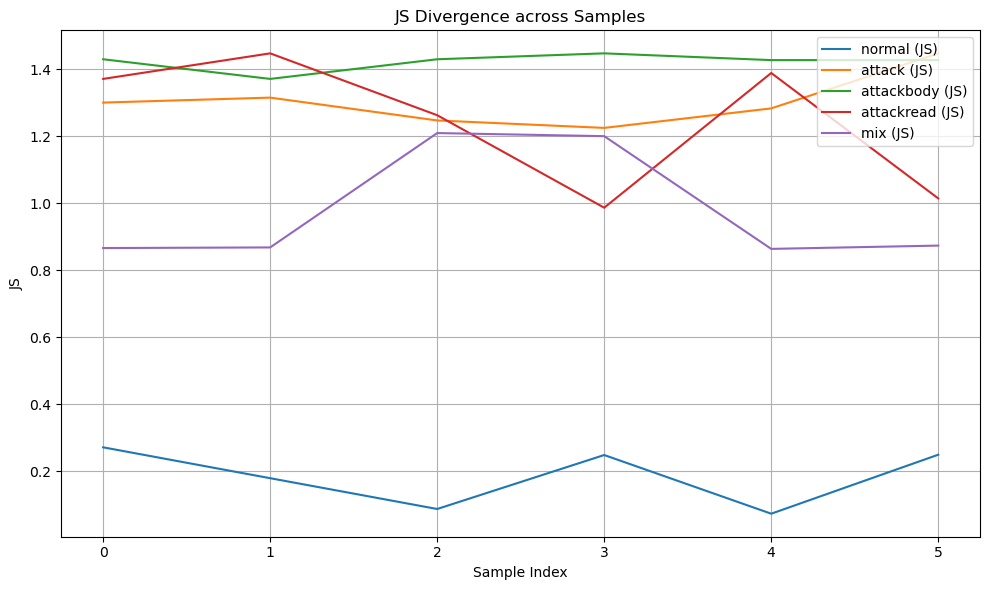

In [8]:
import os
import json
import math
import matplotlib.pyplot as plt

# # 💡 设定基准分布
# baseline_probs = {
# "1-4": 0.042063,
# "1-7": 0.144336,
# "1-8": 0.827621,
# "10-7": 0.805556,
# "2-1": 0.058780,
# "2-7": 0.960813,
# "3-1": 1.000000,
# "4-5": 0.222222,
# "4-7": 0.166667,
# "5-7": 0.222222,
# "7-2": 1.000000,
# "8-9": 1.000000,
# "9-7": 0.979597,
# "9-9": 0.030605,
# }

baseline_probs = {
"1-4": 0.048148,
"1-7": 0.140897,
"1-8": 0.835029,
"10-7": 0.777778,
"2-1": 0.058135,
"2-7": 0.951554,
"3-1": 1.000000,
"4-5": 0.250000,
"4-7": 0.166667,
"5-7": 0.250000,
"7-2": 1.000000,
"8-9": 1.000000,
"9-7": 0.974967,
"9-9": 0.030040,
}

EPSILON=1e-6


def load_probs(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return data.get("probabilities", {})

def to_full_vector(prob_dict, all_keys):
    vec = np.array([prob_dict.get(k, 0.0) for k in all_keys])
    vec = np.clip(vec, EPSILON, 1.0)
    return vec / vec.sum()

# 字典
def kl_divergence(p, q, epsilon=1e-6):
    divergence = 0.0
    for key in p:
        p_val = p.get(key, 0.0)
        q_val = q.get(key, epsilon)
        if p_val > 0:
            divergence += p_val * math.log(p_val / q_val)
    return max(divergence, 0.0)

# 使用向量
def kl_divergence_vector(p_vec, q_vec, epsilon=1e-6):
    """
    KL(p || q) 计算向量版本，p_vec 和 q_vec 都需已归一化。
    """
    kl = np.sum(p_vec * np.log(p_vec / q_vec))
    return max(kl, 0.0)  # 避免负值（理论上不应出现）


# 字典
def js_divergence(p, q, epsilon=1e-6):
    keys = set(p.keys()).union(q.keys())
    m = {k: 0.5 * (p.get(k, 0.0) + q.get(k, 0.0)) for k in keys}
    kl_pm = sum(p.get(k, 0.0) * math.log(p.get(k, 0.0) / max(m[k], epsilon)) for k in keys if p.get(k, 0.0) > 0)
    kl_qm = sum(q.get(k, 0.0) * math.log(q.get(k, 0.0) / max(m[k], epsilon)) for k in keys if q.get(k, 0.0) > 0)
    return 0.5 * (kl_pm + kl_qm)

# 使用向量
def js_divergence_vector(p_vec, q_vec, epsilon=1e-6):
    p_vec = np.clip(p_vec, epsilon, 1)
    q_vec = np.clip(q_vec, epsilon, 1)
    m_vec = 0.5 * (p_vec + q_vec)
    kl_pm = np.sum(p_vec * np.log(p_vec / m_vec))
    kl_qm = np.sum(q_vec * np.log(q_vec / m_vec))
    return 0.5 * (kl_pm + kl_qm)



folders = [ "normal", "attack", "attackbody", "attackread", "mix"]
results = {}

for folder in folders:
    kl_list, js_list = [], []
    if not os.path.exists(folder):
        print(f"⚠️ Folder '{folder}' not found, skipping.")
        continue
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".json"):
            path = os.path.join(folder, fname)
            sample = load_probs(path)

            # 使用字典
            kl = kl_divergence(baseline_probs,sample)
            js = js_divergence(baseline_probs,sample)
            
            
            # 使用向量 + 固定全集 all_keys 的方式来计算 JS 和 KL
            # P_vec = to_full_vector(baseline_probs, baseline_probs)
            # Q_vec = to_full_vector(sample, baseline_probs)
            # kl = kl_divergence_vector(P_vec, Q_vec)
            # js = js_divergence_vector(P_vec, Q_vec)

            kl_list.append(kl)
            js_list.append(js)
            
    results[folder] = {"KL": kl_list, "JS": js_list}

# 📊 画图
for metric in ["KL", "JS"]:
    plt.figure(figsize=(10, 6))
    for folder in folders:
        if folder in results:
            plt.plot(results[folder][metric], label=f"{folder} ({metric})")
    plt.title(f"{metric} Divergence across Samples")
    plt.xlabel("Sample Index")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.legend(loc='upper right')
    # plt.tight_layout()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{metric.lower()}_divergence.png")

# 📋 输出统计信息
print("\n📈 Summary:")
for folder in folders:
    if folder in results and results[folder]["KL"]:
        kl_vals = results[folder]["KL"]
        js_vals = results[folder]["JS"]
        print(f"\n📁 {folder}")
        print(f"  KL Mean: {sum(kl_vals)/len(kl_vals):.4f}, MIN: {min(kl_vals):.4f}")
        print(f"  JS Mean: {sum(js_vals)/len(js_vals):.4f}, MIN: {min(js_vals):.4f}")



📈 Summary:

📁 normal
  KL Mean: 6.2618, MIN: 2.0089
  JS Mean: 0.1848, MIN: 0.0732
  TV Mean: 0.0805, MIN: 0.0512
  Hellinger Mean: 0.1829, MIN: 0.1142

📁 attack
  KL Mean: 26.9550, MIN: 19.6951
  JS Mean: 1.3030, MIN: 1.2249
  TV Mean: 0.3846, MIN: 0.2659
  Hellinger Mean: 0.4677, MIN: 0.4328

📁 attackbody
  KL Mean: 40.3357, MIN: 39.9654
  JS Mean: 1.4221, MIN: 1.3711
  TV Mean: 0.5572, MIN: 0.5314
  Hellinger Mean: 0.5256, MIN: 0.5122

📁 attackread
  KL Mean: 36.3089, MIN: 31.3617
  JS Mean: 1.2452, MIN: 0.9866
  TV Mean: 0.4865, MIN: 0.3725
  Hellinger Mean: 0.4853, MIN: 0.4286

📁 mix
  KL Mean: 2.8479, MIN: 2.7187
  JS Mean: 0.9802, MIN: 0.8637
  TV Mean: 0.2295, MIN: 0.2270
  Hellinger Mean: 0.3111, MIN: 0.3090


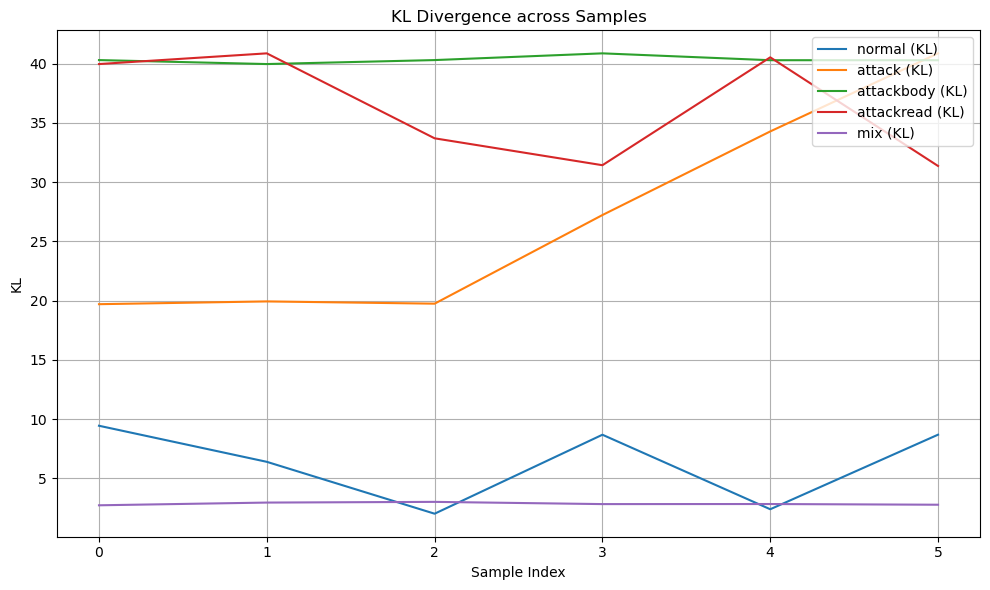

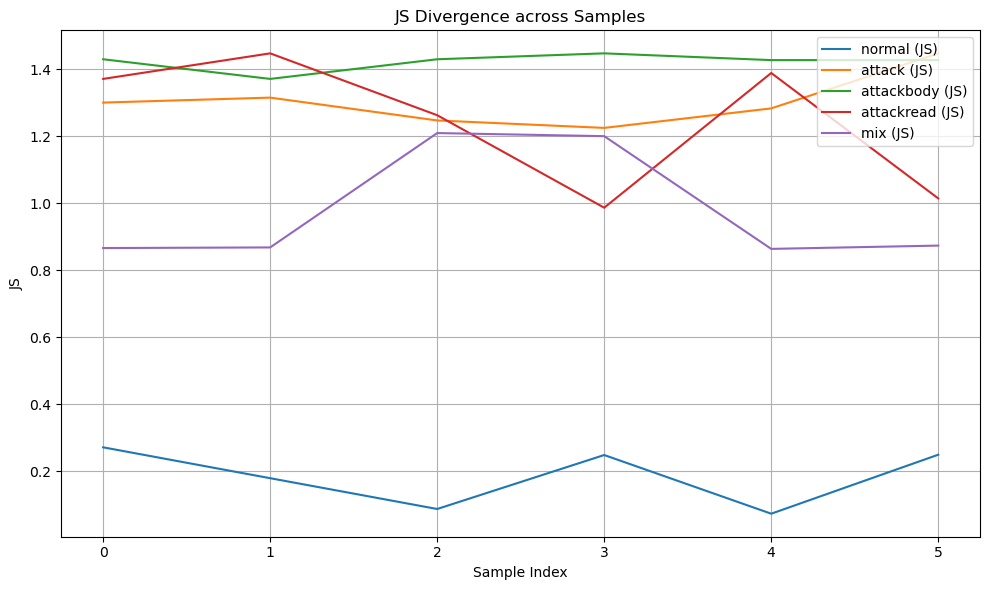

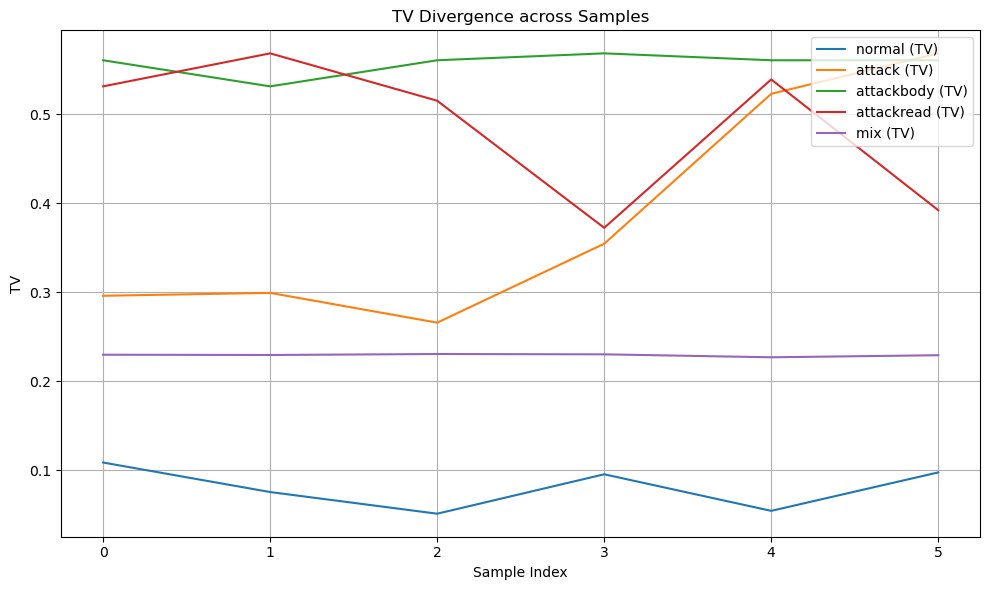

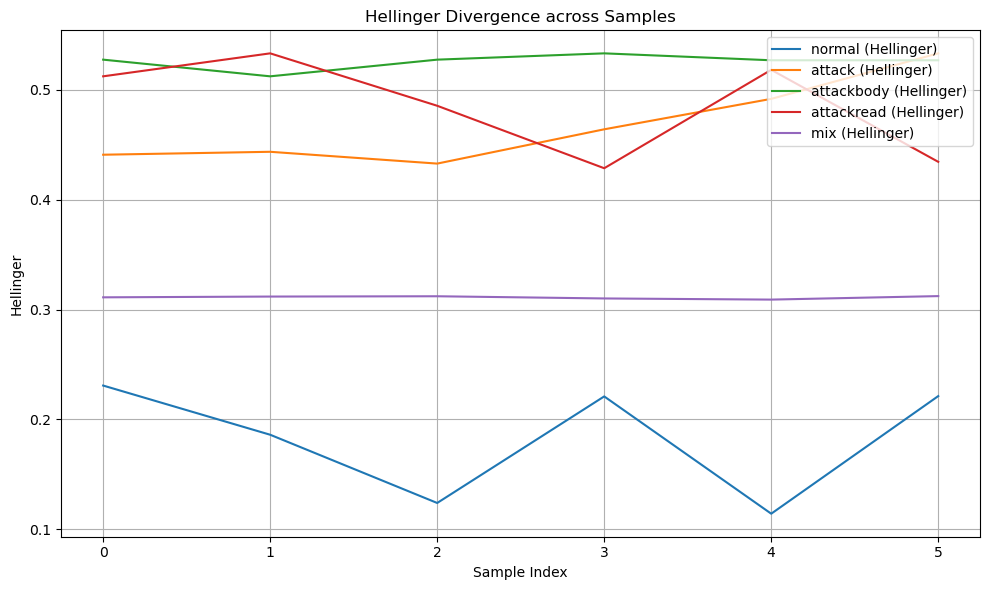

In [12]:

import os
import json
import math
import matplotlib.pyplot as plt

# # 💡 设定基准分布
# baseline_probs = {
# "1-4": 0.042063,
# "1-7": 0.144336,
# "1-8": 0.827621,
# "10-7": 0.805556,
# "2-1": 0.058780,
# "2-7": 0.960813,
# "3-1": 1.000000,
# "4-5": 0.222222,
# "4-7": 0.166667,
# "5-7": 0.222222,
# "7-2": 1.000000,
# "8-9": 1.000000,
# "9-7": 0.979597,
# "9-9": 0.030605,
# }

baseline_probs = {
"1-4": 0.048148,
"1-7": 0.140897,
"1-8": 0.835029,
"10-7": 0.777778,
"2-1": 0.058135,
"2-7": 0.951554,
"3-1": 1.000000,
"4-5": 0.250000,
"4-7": 0.166667,
"5-7": 0.250000,
"7-2": 1.000000,
"8-9": 1.000000,
"9-7": 0.974967,
"9-9": 0.030040,
}

EPSILON=1e-6


def load_probs(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return data.get("probabilities", {})

def to_full_vector(prob_dict, all_keys):
    vec = np.array([prob_dict.get(k, 0.0) for k in all_keys])
    vec = np.clip(vec, EPSILON, 1.0)
    return vec / vec.sum()

# 字典
def kl_divergence(p, q, epsilon=1e-6):
    divergence = 0.0
    for key in p:
        p_val = p.get(key, 0.0)
        q_val = q.get(key, epsilon)
        if p_val > 0:
            divergence += p_val * math.log(p_val / q_val)
    return max(divergence, 0.0)

# 使用向量
def kl_divergence_vector(p_vec, q_vec, epsilon=1e-6):
    """
    KL(p || q) 计算向量版本，p_vec 和 q_vec 都需已归一化。
    """
    kl = np.sum(p_vec * np.log(p_vec / q_vec))
    return max(kl, 0.0)  # 避免负值（理论上不应出现）


# 字典
def js_divergence(p, q, epsilon=1e-6):
    keys = set(p.keys()).union(q.keys())
    m = {k: 0.5 * (p.get(k, 0.0) + q.get(k, 0.0)) for k in keys}
    kl_pm = sum(p.get(k, 0.0) * math.log(p.get(k, 0.0) / max(m[k], epsilon)) for k in keys if p.get(k, 0.0) > 0)
    kl_qm = sum(q.get(k, 0.0) * math.log(q.get(k, 0.0) / max(m[k], epsilon)) for k in keys if q.get(k, 0.0) > 0)
    return 0.5 * (kl_pm + kl_qm)

# 使用向量
def js_divergence_vector(p_vec, q_vec, epsilon=1e-6):
    p_vec = np.clip(p_vec, epsilon, 1)
    q_vec = np.clip(q_vec, epsilon, 1)
    m_vec = 0.5 * (p_vec + q_vec)
    kl_pm = np.sum(p_vec * np.log(p_vec / m_vec))
    kl_qm = np.sum(q_vec * np.log(q_vec / m_vec))
    return 0.5 * (kl_pm + kl_qm)


def tv_distance_vector(p_vec, q_vec):
    return 0.5 * np.sum(np.abs(p_vec - q_vec))

def hellinger_distance_vector(p_vec, q_vec):
    return np.sqrt(0.5 * np.sum((np.sqrt(p_vec) - np.sqrt(q_vec))**2))


folders = [ "normal", "attack", "attackbody", "attackread", "mix"]
results = {}

for folder in folders:
    kl_list, js_list = [], []
    tv_list, hellinger_list = [], []
    if not os.path.exists(folder):
        print(f"⚠️ Folder '{folder}' not found, skipping.")
        continue
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".json"):
            path = os.path.join(folder, fname)
            sample = load_probs(path)

            # 使用字典
            kl = kl_divergence(baseline_probs,sample)
            js = js_divergence(baseline_probs,sample)
            
            
            # 使用向量 + 固定全集 all_keys 的方式来计算 JS 和 KL
            # P_vec = to_full_vector(baseline_probs, baseline_probs)
            # Q_vec = to_full_vector(sample, baseline_probs)
            # kl = kl_divergence_vector(P_vec, Q_vec)
            # js = js_divergence_vector(P_vec, Q_vec)


             # 向量方式：TV 和 Hellinger
            p_vec = to_full_vector(baseline_probs,baseline_probs)
            q_vec = to_full_vector(sample, baseline_probs)
            tv = tv_distance_vector(p_vec, q_vec)
            hellinger = hellinger_distance_vector(p_vec, q_vec)


            kl_list.append(kl)
            js_list.append(js)
            tv_list.append(tv)
            hellinger_list.append(hellinger)
            
    results[folder] = {"KL": kl_list, "JS": js_list,"TV": tv_list,"Hellinger": hellinger_list}

# 📊 画图
for metric in ["KL", "JS", "TV", "Hellinger"]:
    plt.figure(figsize=(10, 6))
    for folder in folders:
        if folder in results:
            plt.plot(results[folder][metric], label=f"{folder} ({metric})")
    plt.title(f"{metric} Divergence across Samples")
    plt.xlabel("Sample Index")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.legend(loc='upper right')
    # plt.tight_layout()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{metric.lower()}_divergence.png")

# 📋 输出统计信息
print("\n📈 Summary:")
for folder in folders:
    if folder in results and results[folder]["KL"]:
        print(f"\n📁 {folder}")
        for metric in ["KL", "JS", "TV", "Hellinger"]:
            vals = results[folder][metric]
            print(f"  {metric} Mean: {sum(vals)/len(vals):.4f}, MIN: {min(vals):.4f}")


📈 Summary:

📁 normal
  KL Mean: 6.2618, MIN: 2.0089
  JS Mean: 0.1848, MIN: 0.0732
  TV Mean: 0.0805, MIN: 0.0512
  Hellinger Mean: 0.1829, MIN: 0.1142

📁 attack
  KL Mean: 26.9550, MIN: 19.6951
  JS Mean: 1.3030, MIN: 1.2249
  TV Mean: 0.3846, MIN: 0.2659
  Hellinger Mean: 0.4677, MIN: 0.4328

📁 attackbody
  KL Mean: 40.3357, MIN: 39.9654
  JS Mean: 1.4221, MIN: 1.3711
  TV Mean: 0.5572, MIN: 0.5314
  Hellinger Mean: 0.5256, MIN: 0.5122

📁 attackread
  KL Mean: 36.3089, MIN: 31.3617
  JS Mean: 1.2452, MIN: 0.9866
  TV Mean: 0.4865, MIN: 0.3725
  Hellinger Mean: 0.4853, MIN: 0.4286

📁 mix
  KL Mean: 2.8479, MIN: 2.7187
  JS Mean: 0.9802, MIN: 0.8637
  TV Mean: 0.2295, MIN: 0.2270
  Hellinger Mean: 0.3111, MIN: 0.3090


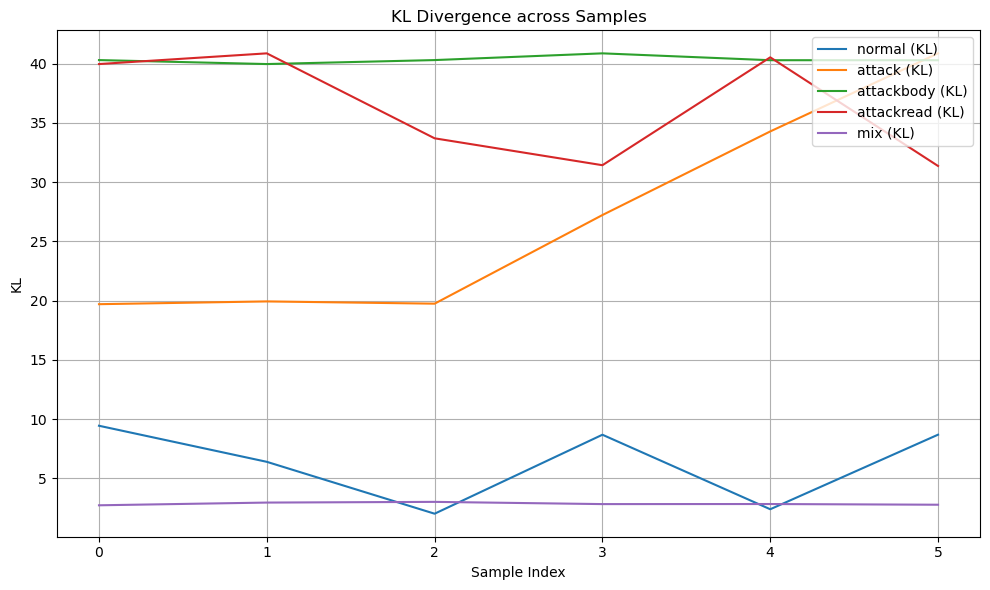

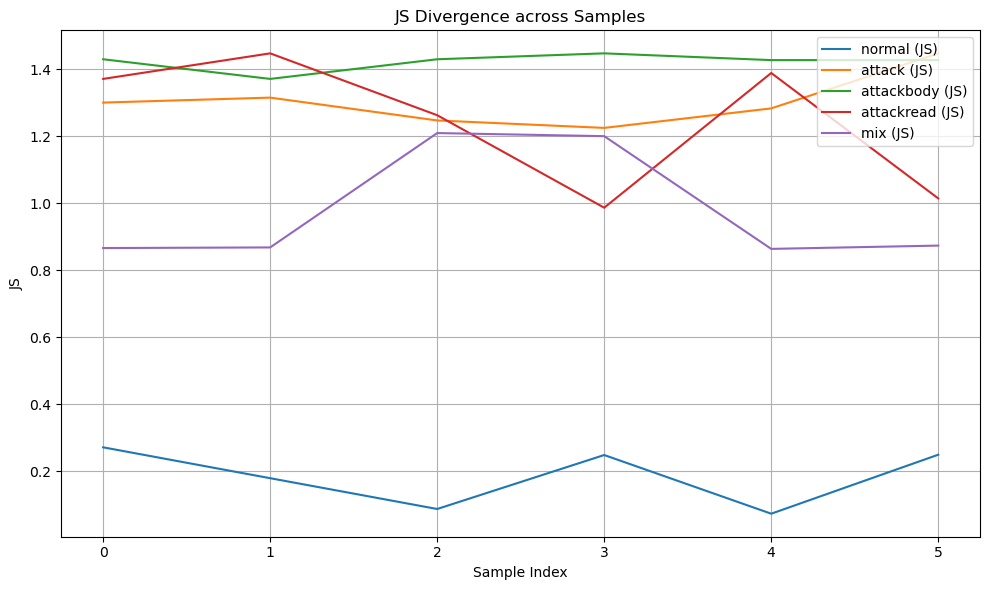

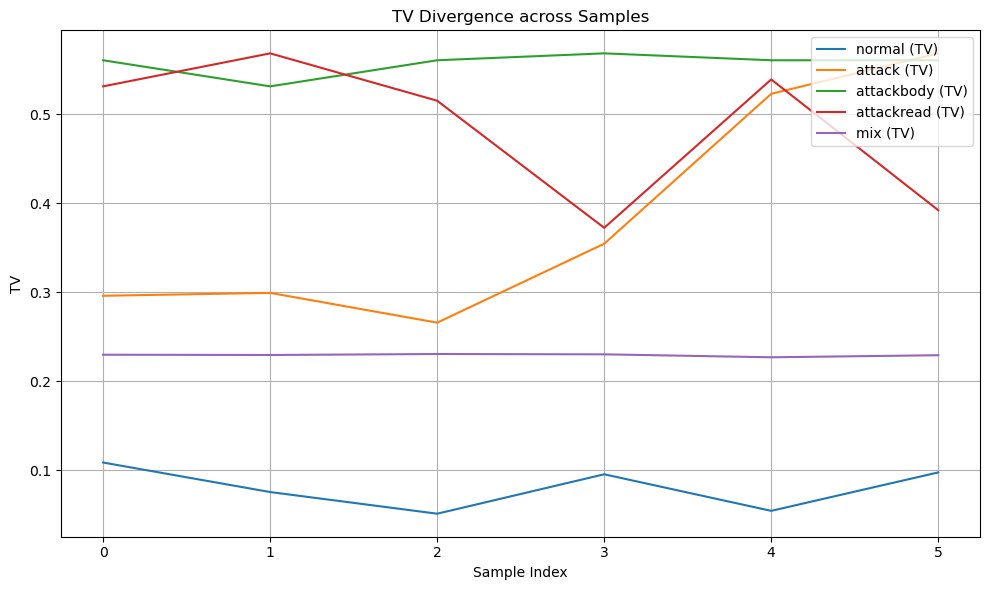

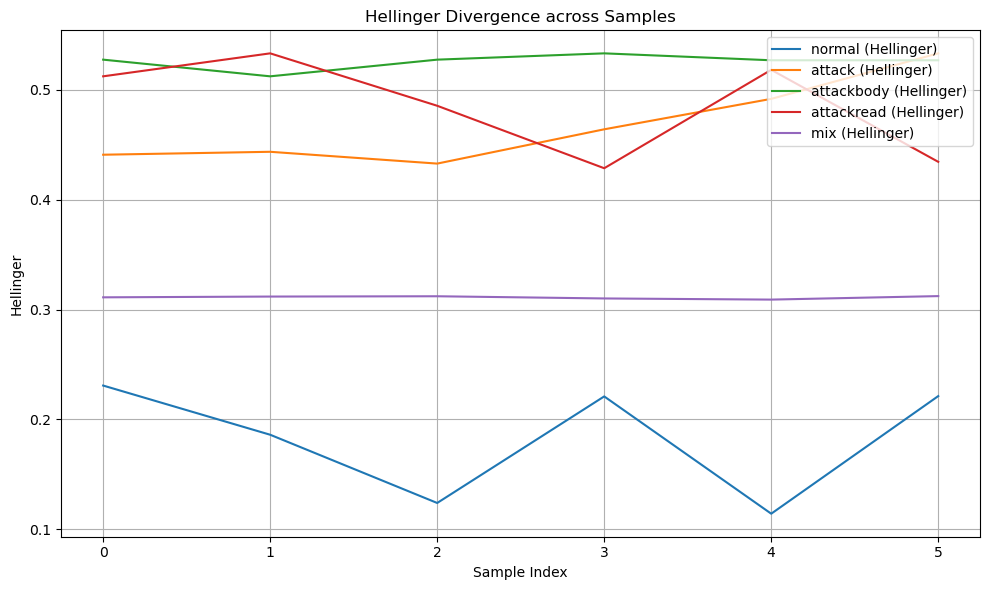

In [12]:

import os
import json
import math
import matplotlib.pyplot as plt

# # 💡 设定基准分布
# baseline_probs = {
# "1-4": 0.042063,
# "1-7": 0.144336,
# "1-8": 0.827621,
# "10-7": 0.805556,
# "2-1": 0.058780,
# "2-7": 0.960813,
# "3-1": 1.000000,
# "4-5": 0.222222,
# "4-7": 0.166667,
# "5-7": 0.222222,
# "7-2": 1.000000,
# "8-9": 1.000000,
# "9-7": 0.979597,
# "9-9": 0.030605,
# }

baseline_probs = {
"1-4": 0.048148,
"1-7": 0.140897,
"1-8": 0.835029,
"10-7": 0.777778,
"2-1": 0.058135,
"2-7": 0.951554,
"3-1": 1.000000,
"4-5": 0.250000,
"4-7": 0.166667,
"5-7": 0.250000,
"7-2": 1.000000,
"8-9": 1.000000,
"9-7": 0.974967,
"9-9": 0.030040,
}

EPSILON=1e-6


def load_probs(filepath):
    with open(filepath) as f:
        data = json.load(f)
    return data.get("probabilities", {})

def to_full_vector(prob_dict, all_keys):
    vec = np.array([prob_dict.get(k, 0.0) for k in all_keys])
    vec = np.clip(vec, EPSILON, 1.0)
    return vec / vec.sum()

# 字典
def kl_divergence(p, q, epsilon=1e-6):
    divergence = 0.0
    for key in p:
        p_val = p.get(key, 0.0)
        q_val = q.get(key, epsilon)
        if p_val > 0:
            divergence += p_val * math.log(p_val / q_val)
    return max(divergence, 0.0)

# 使用向量
def kl_divergence_vector(p_vec, q_vec, epsilon=1e-6):
    """
    KL(p || q) 计算向量版本，p_vec 和 q_vec 都需已归一化。
    """
    kl = np.sum(p_vec * np.log(p_vec / q_vec))
    return max(kl, 0.0)  # 避免负值（理论上不应出现）


# 字典
def js_divergence(p, q, epsilon=1e-6):
    keys = set(p.keys()).union(q.keys())
    m = {k: 0.5 * (p.get(k, 0.0) + q.get(k, 0.0)) for k in keys}
    kl_pm = sum(p.get(k, 0.0) * math.log(p.get(k, 0.0) / max(m[k], epsilon)) for k in keys if p.get(k, 0.0) > 0)
    kl_qm = sum(q.get(k, 0.0) * math.log(q.get(k, 0.0) / max(m[k], epsilon)) for k in keys if q.get(k, 0.0) > 0)
    return 0.5 * (kl_pm + kl_qm)

# 使用向量
def js_divergence_vector(p_vec, q_vec, epsilon=1e-6):
    p_vec = np.clip(p_vec, epsilon, 1)
    q_vec = np.clip(q_vec, epsilon, 1)
    m_vec = 0.5 * (p_vec + q_vec)
    kl_pm = np.sum(p_vec * np.log(p_vec / m_vec))
    kl_qm = np.sum(q_vec * np.log(q_vec / m_vec))
    return 0.5 * (kl_pm + kl_qm)


def tv_distance_vector(p_vec, q_vec):
    return 0.5 * np.sum(np.abs(p_vec - q_vec))

def hellinger_distance_vector(p_vec, q_vec):
    return np.sqrt(0.5 * np.sum((np.sqrt(p_vec) - np.sqrt(q_vec))**2))


folders = [ "normal", "attack", "attackbody", "attackread", "mix"]
results = {}

for folder in folders:
    kl_list, js_list = [], []
    tv_list, hellinger_list = [], []
    if not os.path.exists(folder):
        print(f"⚠️ Folder '{folder}' not found, skipping.")
        continue
    for fname in sorted(os.listdir(folder)):
        if fname.endswith(".json"):
            path = os.path.join(folder, fname)
            sample = load_probs(path)

            # 使用字典
            kl = kl_divergence(baseline_probs,sample)
            js = js_divergence(baseline_probs,sample)
            
            
            # 使用向量 + 固定全集 all_keys 的方式来计算 JS 和 KL
            # P_vec = to_full_vector(baseline_probs, baseline_probs)
            # Q_vec = to_full_vector(sample, baseline_probs)
            # kl = kl_divergence_vector(P_vec, Q_vec)
            # js = js_divergence_vector(P_vec, Q_vec)


             # 向量方式：TV 和 Hellinger
            p_vec = to_full_vector(baseline_probs,baseline_probs)
            q_vec = to_full_vector(sample, baseline_probs)
            tv = tv_distance_vector(p_vec, q_vec)
            hellinger = hellinger_distance_vector(p_vec, q_vec)


            kl_list.append(kl)
            js_list.append(js)
            tv_list.append(tv)
            hellinger_list.append(hellinger)
            
    results[folder] = {"KL": kl_list, "JS": js_list,"TV": tv_list,"Hellinger": hellinger_list}

# 📊 画图
for metric in ["KL", "JS", "TV", "Hellinger"]:
    plt.figure(figsize=(10, 6))
    for folder in folders:
        if folder in results:
            plt.plot(results[folder][metric], label=f"{folder} ({metric})")
    plt.title(f"{metric} Divergence across Samples")
    plt.xlabel("Sample Index")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.legend(loc='upper right')
    # plt.tight_layout()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{metric.lower()}_divergence.png")

# 📋 输出统计信息
print("\n📈 Summary:")
for folder in folders:
    if folder in results and results[folder]["KL"]:
        print(f"\n📁 {folder}")
        for metric in ["KL", "JS", "TV", "Hellinger"]:
            vals = results[folder][metric]
            print(f"  {metric} Mean: {sum(vals)/len(vals):.4f}, MIN: {min(vals):.4f}")